# Instagram Content Classification
*Created by Ade Dwi Aryani*

# 1. Introduction

Instagram merupakan salah satu aplikasi media sosial yang populer digunakan oleh banyak orang di seluruh dunia salah satunya di Indonesia. Berdasarkan fungsinya aplikasi ini digunakan untuk berbagi foto maupun video pada sesama pengguna. Dengan semakin banyaknya pengguna maka postingan yang ada dalam instagram perlu dikelompokkan berdasarkan kategorinya. Keseluruhan postingan juga berpengaruh pada tingkat ketertarikan banyak orang, jika halaman instagram memiliki ciri tersendiri secara visual maka akan menarik minat orang untuk mengikuti halaman tersebut khususnya bagi orang yang memiliki selera yang sama.

Analisis ini bertujuan mengklasifikasi halaman instagram secara visual atau citra pada tangkapan layar menggunakan metode Convolutional Neural Network dan EfficientNetB2. Klasifikasi tangkapan layar halaman instagram pada penelitian ini dibagi menjadi 5 kelas, yaitu Beauty, Family, Fashion, Fitness, dan Food dengan total data citra 1500 tangkapan layar halaman instagram.


## 2. Import Libraries

Sebelum memulai analisis *image classification* diperlukan berbagai pustaka atau library yang dapat memudahkan proses. Pustaka yang dibutuhkan harus sesuai dengan data, model, dan metode yang digunakan dalam analisis. Pustaka yang dibutuhkan pada analisis ini adalah sebagai berikut:

In [ ]:
from google.colab import drive
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import pathlib
import random
import shutil
from tqdm import tqdm

# For Preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For Modelling
from tensorflow.keras.applications import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Saving Model
from keras.models import load_model

# For Data Inference
from google.colab import files
from tensorflow.keras.preprocessing import image

# 3. Data Loading

Dataset yang akan digunakan berada di file google drive. Untuk menghubungkan file yang ada di google drive dengan google colab, maka harus dilakukan mounting google drive pada directory google colab. Setelah dilakukan mounting maka sebuah folder ‘gdrive’ akan muncul pada directory VM Google Colab. 

In [ ]:
# Mounting the drive with name 'gdrive'
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Untuk mengakses folder, maka harus mengubah directory google drive sebagai berikut.

In [ ]:
# Change to the google drive directory
% cd /content/gdrive/MyDrive/instagram_cnn

/content/gdrive/MyDrive/instagram_cnn


Untuk memastikan sudah berada di folder yang tepat, dapat menggunakan `! pwd`.

In [ ]:
# For verifying
! pwd

/content/gdrive/MyDrive/instagram_cnn


# 4. Exploratory Data Analysis (EDA)

In [ ]:
# Show Random Image
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  # Random Sample Image
  random_image = random.sample(os.listdir(target_folder), 1)

  images = imread(target_folder + "/" + random_image[0])
  plt.imshow(images)
  plt.title(f"Shape: {images.shape}", fontsize=10)
  plt.axis("off");
  return images

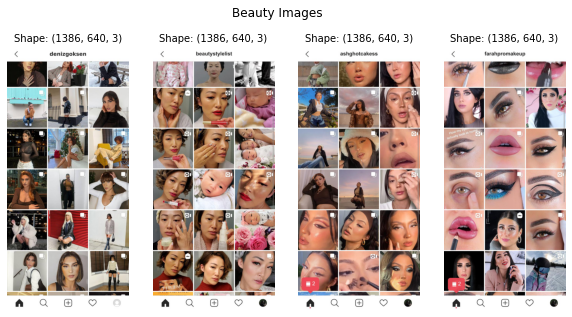

In [ ]:
# Plot Beauty Image
plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(1, 4, i+1)
  images = view_random_image(target_dir='instagram_img/train/', target_class='beauty')
  plt.imshow(images)

plt.suptitle('Beauty Images')
plt.show()

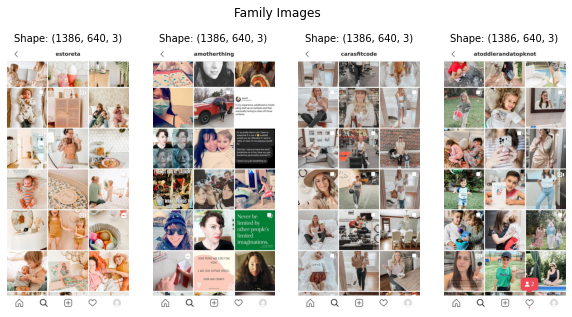

In [ ]:
# Plot Family Image
plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(1, 4, i+1)
  images = view_random_image(target_dir='instagram_img/train/', target_class='family')
  plt.imshow(images)

plt.suptitle('Family Images')
plt.show()

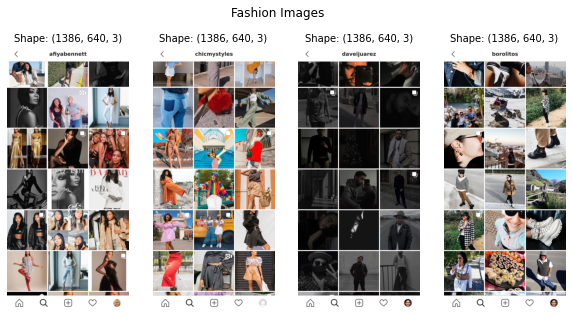

In [ ]:
# Plot Fashion Image
plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(1, 4, i+1)
  images = view_random_image(target_dir='instagram_img/train/', target_class='fashion')
  plt.imshow(images)

plt.suptitle('Fashion Images')
plt.show()

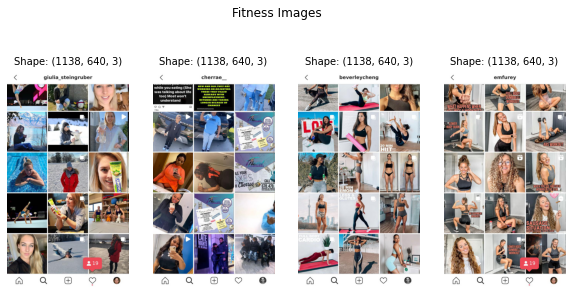

In [ ]:
# Plot Fitness Image
plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(1, 4, i+1)
  images = view_random_image(target_dir='instagram_img/train/', target_class='fitness')
  plt.imshow(images)

plt.suptitle('Fitness Images')
plt.show()

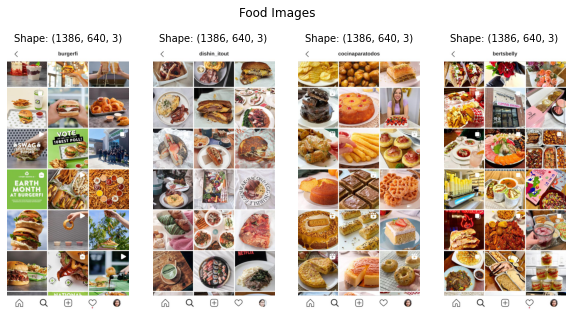

In [ ]:
# Plot Food Image
plt.figure(figsize=(10,5))
for i in range(4):
  plt.subplot(1, 4, i+1)
  images = view_random_image(target_dir='instagram_img/train/', target_class='food')
  plt.imshow(images)

plt.suptitle('Food Images')
plt.show()

# 5. Data Preprocessing

Data preprocessing berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-test, transformasi data, dan proses-proses lain yang dibutuhkan. 

Pada analisis ini, dataset dibagi menjadi dua yaitu data train dan data test. Pembagian dilakukan secara manual dengan perbandingan 8:2 (80% data train, 20% data test), dari pembagian tersebut data kemudian dibagi menjadi dua folder. Untuk melihat jumlah dari setiap data pada masing-masing folder, dapat mengatur *directory*, kemudian untuk melihat data pada setiap target class dapat menggunakan `os.path.join`. Jumlah data pada data train dan data test untuk masing-masing target classnya adalah sebagai berikut:

In [ ]:
# Set Directory
train_dir = 'instagram_img/train/'
test_dir = 'instagram_img/test/'

# Set Directory trainset for Target Class
train_beauty  = os.path.join(train_dir, 'beauty/')
train_family  = os.path.join(train_dir, 'family/')
train_fashion = os.path.join(train_dir, 'fashion/')
train_fitness = os.path.join(train_dir, 'fitness/')
train_food    = os.path.join(train_dir, 'food/')

print('Number of Data Training by Target Class')
print('beauty  :', len(os.listdir(train_beauty)))
print('Rain    :', len(os.listdir(train_family)))
print('fashion :', len(os.listdir(train_fashion)))
print('fitness :', len(os.listdir(train_fitness)))
print('food    :', len(os.listdir(train_food)))

# Set Directory Testing for Target Class
test_beauty  = os.path.join(test_dir, 'beauty/')
test_family  = os.path.join(test_dir, 'family/')
test_fashion = os.path.join(test_dir, 'fashion/')
test_fitness = os.path.join(test_dir, 'fitness/')
test_food   = os.path.join(test_dir, 'food/')

print(' ')
print('Number of Data Testing by Target Class')
print('beauty  :', len(os.listdir(test_beauty)))
print('Rain    :', len(os.listdir(test_family)))
print('fashion :', len(os.listdir(test_fashion)))
print('fitness :', len(os.listdir(test_fitness)))
print('food    :', len(os.listdir(test_food)))

Number of Data Training by Target Class
beauty  : 240
Rain    : 240
fashion : 240
fitness : 240
food    : 240
 
Number of Data Testing by Target Class
beauty  : 60
Rain    : 60
fashion : 60
fitness : 60
food    : 60


Pada Tensorflow kita bisa menggunakan perintah berikut untuk meload dataset. Objek datagen adalah objek ImageDataGenerator() yang berfungsi untuk memproses data sebelum di load. Ada banyak fungsi di dalamnya. Pada analisis ini model yang akan digunakan ada 2, yaitu Convolutional Neural Network dan EfficientNet. Pada model EfficientNet, tidak diperlukan parameter rescale, sehingga training pada model ini akan menggunakan data tanpa augmented. 

Sedangkan pada model Convolutional Neural Network, data test dan train akan diaugmented. Data test augmented hanya menambahkan parameter resacle. Fungsi rescale digunakan untuk mengubah skala nilai pada data image. Ketika data image itu di load, data image direpresentasikan sebagai array 3D (atau Tensor) dengan nilai rentangan antara 0..255. Pada parameter rescale bernilai “1/255” yang artinya setiap nilai akan dikali 1/255 sehingga rentangan nilainya akan berubah diantara 0..1. Data train agumented menambahkan parameter rescale untuk rescaling data menjadi 1/255, Shearing image skala 0.2, Zooming image dengan range 0.2 dan melakukan Horizontal flip.

Hasil dari ImageDataGenerator() kemudian akan dihubungkan dengan directory data train dan data test dengan menggunakan `flow_from_directory`. Parameter yang ditambahkan adalah :
1. batch_size=30,
2. shuffle=True,
3. target_size=(200, 100),
4. class_mode='categorical'.

In [ ]:
# Declare Data Image
train_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen = ImageDataGenerator()
train_datagen_aug = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen_aug = ImageDataGenerator(rescale = 1./255)

# Flow_from_directory for Generate Image
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=30,
                                               shuffle=True,
                                               target_size=(200, 100),
                                               class_mode='categorical')

val_data   = val_datagen.flow_from_directory(test_dir,
                                               batch_size=30,
                                               shuffle=True,
                                               target_size=(200, 100),
                                               class_mode='categorical')

train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                               batch_size=30,
                                               shuffle=True,
                                               target_size=(200, 100),
                                               class_mode='categorical')

val_data_aug   = val_datagen_aug.flow_from_directory(test_dir,
                                               batch_size=30,
                                               shuffle=True,
                                               target_size=(200, 100),
                                               class_mode='categorical')

Found 1200 images belonging to 5 classes.
Found 300 images belonging to 5 classes.
Found 1200 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


Hasil dari perintah tersebut akan menghasilkan object Tensorflow Dataset, sebuah object yang memudahkan proses pengolahan dataset.

# 6. Model Definition

## Base Model / Model 1

Model 1 didefinisikan dengan `Sequential API`. Arsitektur Convolutional Neural Network pada Model 1 dimulai dari citra input berukuran 200×100 (sesuai shape gambar). Model ini terdapat 2 layer konvolusi dan 2 layer pooling. Pada layer konvolusi pertama dengan jumlah feature map 64, ukuran kernel 3×3, dan menggunakan aktivasi ReLu. Hasil konvolusi pertama lalu dimasukkan pada pooling layer menggunakan max pooling (matriks 2x2). Jumlah feature map pada layer konvolusi kedua yaitu 32, dengan pooling layer yang sama yaitu menggunakan matriks 2x2.

Model selanjutnya diubah menjadi vektor atau 1 dimensi dengan flatten agar dapat masuk pada fully connected layer. 

Pada bagian fully connected layer terdapat operasi neural network dengan 1 hidden layer dengan jumlah neuron 128 dan menggunakan aktivasi ReLu. Pada output digunakan fungsi aktivasi softmax yang digunakan untuk merubah hasil output dalam distribusi probabilitas menyesuaikan klasifikasi yang dihasilkan output, kelas pada dataset adalah multiclass sehingga menggunakan fungsi aktivasi softmax, angka 5 merupakan jumlah kelas yang terdapat pada dataset.

Model kemudian dicompile menggunakan parameter:
1. loss : categorical_crossentropy, karena class pada dataset berupa multiclass
2. optimizer : Adammax dengan learning_rate=0.0001, dan
3. metrics : accuracy.

In [ ]:
# Define Model_1 Convolutional Neural Network
model_1 = Sequential()

# Convulation & Maxpooling
model_1.add(Conv2D(64, 3, activation='relu', input_shape=(200, 100, 3)))
model_1.add(MaxPool2D(2,2))
model_1.add(Conv2D(32, 3, activation='relu'))
model_1.add(MaxPool2D(2,2))

# Flattening
model_1.add(Flatten())

# Dense Neural Network with 1 Hidden Layer
model_1.add(Dense(128, activation = 'relu'))
model_1.add(Dropout(0.45, seed=123))
model_1.add(Dense(5, activation="softmax"))

# Compile Model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adamax(learning_rate=0.0001),
    metrics=["accuracy"])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 98, 64)       1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 47, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 35328)             0         
                                                                 
 dense (Dense)               (None, 128)               4

## Model 2

Model 2 juga didefinisikan dengan `Sequential API`. Model yang digunakan adalah EfficientNetB2 dengan parameter weights="imagenet", include_top=False, pooling='max'. Kemudian model akan dinormalisasi menggunakan BatchNormalization agar distribusi input ke fully connected layer tidak berubah seiring waktu karena pembaruan parameter dari setiap batch (atau berubah dengan cara yang menguntungkan).

Pada fully connected layer, di hidden layer ditambahkan parameter regularizer. Model compile sama seperti Model 1.

In [ ]:
# Define Model_2 EfficientNetB2
model_2 = Sequential()
model_2.add(EfficientNetB2(weights="imagenet", include_top=False, pooling='max', input_shape=(200, 100, 3)))

# Define BatchNormalization
model_2.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

# Dense Neural Network with 1 Hidden Layer and Dropout 0.45
model_2.add(Dense(128, kernel_regularizer = regularizers.l2(l = 0.001), activity_regularizer=regularizers.l1(0.0001),
                bias_regularizer=regularizers.l1(0.0001), activation = 'relu'))
model_2.add(Dropout(0.45, seed=123))
model_2.add(Dense(5, activation="softmax"))

# Compile Model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adamax(learning_rate=0.0001),
    metrics=["accuracy"])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 batch_normalization (BatchN  (None, 1408)             5632      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               180352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 7,955,198
Trainable params: 7,884,807
Non-trainable params: 70,391
_______________________________________

# 7. Model Training

Cell pada bagian ini berisi code untuk melatih model dan output yang dihasilkan. Terdapat 2 training karena menyesuaikan jumlah model. Parameter yang ditambahkan yaitu epochs=30. Jumlah epoch adalah hyperparameter yang menentukan berapa kali algoritma pembelajaran akan bekerja mengolah seluruh dataset training. Satu epoch berarti bahwa setiap sampel dalam dataset training memiliki kesempatan untuk memperbarui parameter model internal. Jumlah epochs sama dengan 30 artinya algoritma akan ditraining berulang selama 30 kali. Verbose yang digunakan adalah 1.

In [ ]:
# Training Model 1 Convolutional Neural Network
history_1 = model_1.fit(train_data_aug,
                    epochs=30,
                    validation_data=val_data_aug,
                    validation_steps=None,
                    verbose=1)

Epoch 1/30
40/40 [==============================] - 36s 776ms/step - loss: 1.6131 - accuracy: 0.2400 - val_loss: 1.5613 - val_accuracy: 0.4600
Epoch 2/30
40/40 [==============================] - 31s 773ms/step - loss: 1.5713 - accuracy: 0.2817 - val_loss: 1.5199 - val_accuracy: 0.3267
Epoch 3/30
40/40 [==============================] - 30s 743ms/step - loss: 1.5191 - accuracy: 0.3642 - val_loss: 1.4461 - val_accuracy: 0.5333
Epoch 4/30
40/40 [==============================] - 29s 738ms/step - loss: 1.4682 - accuracy: 0.3900 - val_loss: 1.3881 - val_accuracy: 0.5233
Epoch 5/30
40/40 [==============================] - 29s 733ms/step - loss: 1.4191 - accuracy: 0.4425 - val_loss: 1.3307 - val_accuracy: 0.5300
Epoch 6/30
40/40 [==============================] - 29s 731ms/step - loss: 1.3695 - accuracy: 0.4483 - val_loss: 1.2711 - val_accuracy: 0.5300
Epoch 7/30
40/40 [==============================] - 29s 720ms/step - loss: 1.3341 - accuracy: 0.4842 - val_loss: 1.2391 - val_accuracy: 0.5133

In [ ]:
# Training Model 2 With Dropout
history_2 = model_2.fit(train_data,
                    epochs=30,
                    validation_data=val_data,
                    validation_steps=None,
                    verbose = 1)

Epoch 1/30
40/40 [==============================] - 51s 803ms/step - loss: 2.6284 - accuracy: 0.2592 - val_loss: 2.6765 - val_accuracy: 0.2067
Epoch 2/30
40/40 [==============================] - 29s 720ms/step - loss: 2.1018 - accuracy: 0.3558 - val_loss: 2.3362 - val_accuracy: 0.2767
Epoch 3/30
40/40 [==============================] - 30s 736ms/step - loss: 1.8079 - accuracy: 0.4217 - val_loss: 1.9333 - val_accuracy: 0.3900
Epoch 4/30
40/40 [==============================] - 30s 733ms/step - loss: 1.6053 - accuracy: 0.5150 - val_loss: 1.6388 - val_accuracy: 0.5100
Epoch 5/30
40/40 [==============================] - 29s 728ms/step - loss: 1.4726 - accuracy: 0.5358 - val_loss: 1.4195 - val_accuracy: 0.5467
Epoch 6/30
40/40 [==============================] - 29s 729ms/step - loss: 1.3598 - accuracy: 0.5908 - val_loss: 1.2620 - val_accuracy: 0.5867
Epoch 7/30
40/40 [==============================] - 29s 727ms/step - loss: 1.1522 - accuracy: 0.6483 - val_loss: 1.1504 - val_accuracy: 0.6333

# 8. Model Evaluation

Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model.

## Plot Accuracy and Loss

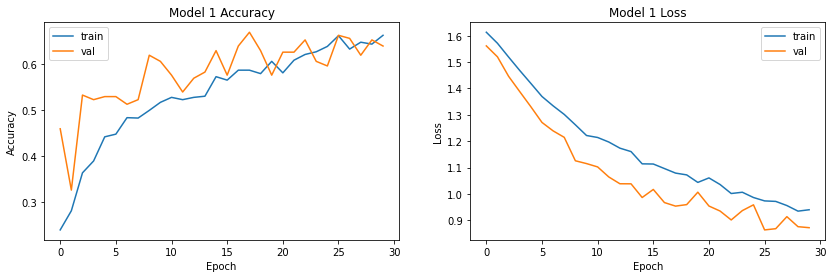

In [ ]:
# Evaluate Model 1 Without Dropout Data Train Not Augmented

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Berdasarkan plot accuracy dan Loss, dapat diperoleh informasi bahwa Model 1 overfitting. Nilai accuracy berada di rentang 0.3 hingga 07, dan loss berada di bawah 1.5. Hal ini menunjukkan bahwa Model 1 merupakan model yang tidak baik berdasarkan accuracy dan lossnya, karena memiliki accuracy yang cukup rendah dan loss yang cenderung tinggi.

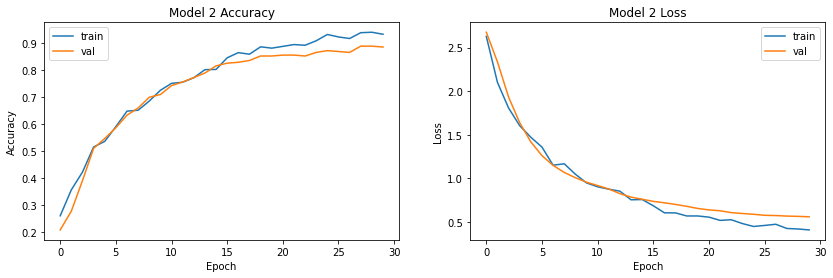

In [ ]:
# Plot Evaluate Model 2 Dropout 0.5 Data Train Not Augmented

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Model 2 tidak overfitting jika dilihat pada plot accuracy dan Lossnya. Nilai accuracy berada di rentang 0.6 hingga 0.9, dan loss berada di bawah 1.5. Hal ini menunjukkan bahwa Model 2 merupakan model yang baik berdasarkan accuracy dan lossnya, karena memiliki accuracy yang tinggi dan loss yang rendah. Jika dibandingkan dengan Model 1, dapat dilihat bahwa Model 2 lebih baik karena Model 2 memiliki accuracy yang lebih tinggi dan nilai loss yang lebih rendah. Dapat diartikan bahwa dalam analisis ini Model EfficientNetB2 merupakan model yang lebih baik daripada Model Convolutional Neural Network.

## Classification Report

In [ ]:
# Classification Report Model 1

# Define Test Data
test_data_1 = val_datagen_aug.flow_from_directory(test_dir,
                                               batch_size=30,
                                               shuffle=False,
                                               target_size=(200, 100),
                                               class_mode='categorical')

#Predict classes
test_steps_per_epoch = np.math.ceil(test_data_1.samples / test_data_1.batch_size)

predictions = model_1.predict(test_data_1, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1) 

# Get ground-truth classes and class-labels
true_classes = test_data_1.classes
class_labels = list(test_data_1.class_indices.keys())    

# Use scikit-learn to get statistics
matrix = confusion_matrix(true_classes, predicted_classes)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(' ')
print('Confusion matrix Model 1')
print(matrix)
print(' ')
print('Classification report Model 1')
print(report)  

Found 300 images belonging to 5 classes.
 
Confusion matrix Model 1
[[27  0 28  1  4]
 [ 0  1 39 15  5]
 [ 0  0 56  3  1]
 [ 1  1  2 56  0]
 [ 0  0  7  1 52]]
 
Classification report Model 1
              precision    recall  f1-score   support

      beauty       0.96      0.45      0.61        60
      family       0.50      0.02      0.03        60
     fashion       0.42      0.93      0.58        60
     fitness       0.74      0.93      0.82        60
        food       0.84      0.87      0.85        60

    accuracy                           0.64       300
   macro avg       0.69      0.64      0.58       300
weighted avg       0.69      0.64      0.58       300



Tingkat nilai accuracy sebesar 64%, precision sebesar 69%, recall sebesar 64%, dan F1-Score sebesar 58%. Tingkat akurasi model convolutional neural network sebesar 64% yang artinya tidak cukup baik dalam mengklasifikasikan gambar tangkapan layar halaman instagram.

Selain itu, pada confusion matrix, yang berhasil diprediksi secara benar ada 192 gambar, sedangkan sisanya yaitu sebanyak 108 gambar diprediksi pada kelas yang salah.

In [ ]:
# Classification Report Model 2

# Define Test Data
test_data_2 = val_datagen.flow_from_directory(test_dir,
                                               batch_size=30,
                                               shuffle=False,
                                               target_size=(200, 100),
                                               class_mode='categorical')

# Predict classes
test_steps_per_epoch = np.math.ceil(test_data_2.samples / test_data_2.batch_size)

predictions = model_2.predict(test_data_2, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1) 

# Get ground-truth classes and class-labels
true_classes = test_data_2.classes
class_labels = list(test_data_2.class_indices.keys())    

# Use scikit-learn to get statistics
matrix = confusion_matrix(true_classes, predicted_classes)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(' ')
print('Confusion matrix Model 2:')
print(matrix)
print(' ')
print('Classification report Model 2:')
print(report)  

Found 300 images belonging to 5 classes.
 
Confusion matrix Model 2:
[[55  4  1  0  0]
 [ 0 52  4  4  0]
 [ 1 10 45  4  0]
 [ 2  2  1 54  1]
 [ 0  0  0  0 60]]
 
Classification report Model 2:
              precision    recall  f1-score   support

      beauty       0.95      0.92      0.93        60
      family       0.76      0.87      0.81        60
     fashion       0.88      0.75      0.81        60
     fitness       0.87      0.90      0.89        60
        food       0.98      1.00      0.99        60

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



Tingkat nilai accuracy sebesar 89%, precision sebesar 89%, recall sebesar 89%, dan F1-Score sebesar 89%. Tingkat akurasi model convolutional neural network sebesar 89% yang artinya cukup baik dalam mengklasifikasikan gambar tangkapan layar halaman instagram.

Selain itu, pada confusion matrix, yang berhasil diprediksi secara benar ada 266 gambar, sedangkan sisanya yaitu sebanyak 34 gambar diprediksi pada kelas yang salah. Hal ini membuktikan bahwa Model EfficientNet merupakan model yang lebih baik dibandingkan CNN (dalam kasus analis ini).

## Best Model Selection

Model terbaik akan dipilih berdasarkan nilai accuracy dan loss. Model terbaik adalah model yang memiliki nilai accuracy yang paling tinggi dan nilai loss yang paling rendah.

In [ ]:
# Create Metrics Evaluation Dataframe
metrics_eval = pd.DataFrame({'Model': [],
                             'Dropout': [],
                             'Loss':[],
                             'Accuracy':[]})

# Loss & Accuracy Model 1
score_model_1 = model_1.evaluate(val_data)
loss_1 = score_model_1[0]
accuracy_1 =  score_model_1[1]

# Loss & Accuracy Model 2
score_model_2 = model_2.evaluate(val_data)
loss_2 = score_model_2[0]
accuracy_2 =  score_model_2[1]

# Metrics Evaluation
r = metrics_eval.shape[0]
metrics_eval.loc[r] = ['Convolutional Neural Network', '0.45', loss_1, accuracy_1]
metrics_eval.loc[r+1] = ['EfficientNetB2', '0.45', loss_2, accuracy_2]
metrics_eval

10/10 [==============================] - 5s 486ms/step - loss: 0.5611 - accuracy: 0.8867


,Model,Dropout,Loss,Accuracy
0,Convolutional Neural Network,0.45,97.095650,0.603333
1,EfficientNetB2,0.45,0.561078,0.886667


Berdasarkan data tersebut, dapat disimpulkan bahwa model terbaik adalah Model 2 yaitu model EffecientNetB2 dengan parameter tertentu. Hal ini karena Model 2 memiliki nilai loss lebih rendah dan accuracy lebih tinggi dibandingkan Model 1.

# 9. Model Saving

Dengan melihat hasil evaluasi model, model terbaik yaitu model 2 akan disimpan. Model terbaik ini akan digunakan kembali dalam melakukan deployment di Heroku. Link Heroku untuk analisis ini adalah sebagai berikut :

In [ ]:
# Saving and Loading the .h5 Model
 
# Save Model
model_2.save('/content/gdrive/MyDrive/instagram_cnn/final_model.h5')
print('Model Saved!')
 
# Load Model
final_model = load_model('/content/gdrive/MyDrive/instagram_cnn/final_model.h5')
final_model.summary()

Model Saved!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 1408)             7768569   
                                                                 
 batch_normalization (BatchN  (None, 1408)             5632      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               180352    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 7,955,198
Trainable params: 7,884,807
Non-trainable params: 70,391
__________________________

# 10. Model Inference

Model yang sudah dilatih akan dicoba pada data inference. Data inference yang digunakan adalah data  yang bukan termasuk ke dalam train-set ataupun test-set, data tersebut berada di folder `instagram_img/`. Berikut adalah fungsi untuk memprediksi class pada data inference.

In [ ]:
def predict(path):
    """This functions returns predictions for a given input image

    Parameters: 
    path: path of the image to predict

    """
    #Creating a dictionary of classes as the predict function gives probablities
    actualClasses = { 0:'Beauty',1:'Family',2:'Fashion',3:'Fitness', 4:'Food'}

    img = image.load_img(path, target_size = (200, 100))
    img_array = image.img_to_array(img)

    #Plotting the image
    plt.imshow(img_array/255)
    plt.show()
    img_array = np.expand_dims(img_array, axis=0)

    #Prediction
    pred = final_model.predict(img_array)
    classes = np.argmax(pred)
    return 'Predicted Class : {}'.format(actualClasses[classes])

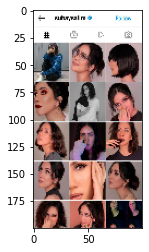

'Predicted Class : Beauty'

In [ ]:
predict(path='/content/gdrive/MyDrive/instagram_cnn/instagram_img/beauty.jpg')

Model dapat memprediksi Gambar Beauty ke dalam kelas Beauty.

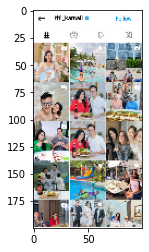

'Predicted Class : Family'

In [ ]:
predict(path='/content/gdrive/MyDrive/instagram_cnn/instagram_img/family-1.jpg')

Model dapat memprediksi Gambar Family ke dalam class Family.

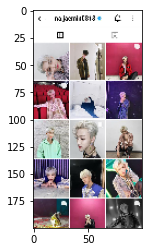

'Predicted Class : Fashion'

In [ ]:
predict(path='/content/gdrive/MyDrive/instagram_cnn/instagram_img/fashion.jpg')

Model dapat memprediksi Gambar Fashion ke dalam class Fashion.

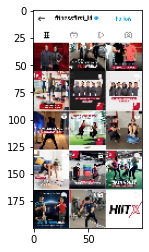

'Predicted Class : Fitness'

In [ ]:
predict(path='/content/gdrive/MyDrive/instagram_cnn/instagram_img/fitness.jpg')

Model dapat memprediksi Gambar Fitness ke dalam kelas Fitness.

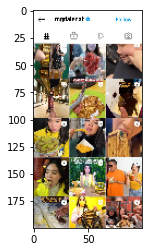

'Predicted Class : Food'

In [ ]:
predict(path='/content/gdrive/MyDrive/instagram_cnn/instagram_img/food.jpg')

Model dapat memprediksi Gambar Food ke dalam kelas Food.

Dapat disimpulkan bahwa model terbaik, yaitu Model 2 dapat digunakan untuk mengklasifikasikan instagram ke dalam 5 kelas (beauty, family, food, fashion, dan fitness).

## 11. Conclusion

Berikut adalah kesimpulan untuk analisis ini :
1. Terdapat lima kelas content instagram pada data train maupun test, yaitu beauty, family, food, fashion, dan fitness. Data dari masing-masing kelas seimbang atau balanced, yaitu pada data train sebanyak 240 gambar per kelas dan pada test sebanyak 60 gambar per kelas.
2. Model yang digunakan adalah model Convolutional Neural Network (CNN) dan EfficientNetB2. Pendefinisian keduanya menggunakan Sequential API. 

3. Berdasarkan plot accuracy dan lossnya, model 1 overfitting, dan model 2 tidak overfitting. Hal ini menunjukkan bahwa pada analisis ini model EfficientNet lebih baik dibandingkan model CNN.

4. Model terbaik adalah Model 2 yaitu model EffecientNetB2 dengan parameter tertentu. Hal ini karena Model 2 memiliki nilai loss lebih rendah dan accuracy lebih tinggi dibandingkan Model 1.

5. Berdasarkan data inference, Model tersebut dapat digunakan untuk mengklasifikasikan konten instagram ke dalam 5 kelas (beauty, family, food, fashion, dan fitness).

**link google colab** : https://colab.research.google.com/drive/1K-vtOXAHKqR_oS0vHQA3Ph7-4hzgh5De?usp=sharing